Project description
===

Here we have a dataset on Yandex.Afisha visits, orders and marketing expenses. We want to explore users' behaviour patterns. It would allow us to optimize marketing campaigns.

First, we should do some data preprocessing: clean the data, fill in the missing values (if any), and change data types. Also, we need to add some new columns to help our analysis. After doing so, we could explore our data.
<br /><br />

**Description of the data**
```
The visits table (server logs with data on website visits):
    Uid — user's unique identifier
    Device — user's device
    Start Ts — session start date and time
    End Ts — session end date and time
    Source Id — identifier of the ad source the user came from

The orders table (data on orders):
    Uid — unique identifier of the user making an order
    Buy Ts — order date and time
    Revenue — Yandex.Afisha's revenue from the order
    
The costs table (data on marketing expenses):
    source_id — ad source identifier
    dt — date
    costs — expenses on this ad source on this day
```

## Open the data and study the general information

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display_html
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
visits_dtype = {'Device': 'category', 'Source Id': 'category'}
visits_dates = ['Start Ts', 'End Ts']
orders_dtype = {'Revenue': 'float32'}
orders_dates = ['Buy Ts']
costs_dtype = {'source_id': 'category', 'costs': 'float32'}
costs_dates = ['dt']

try:
    visits = pd.read_csv('./datasets/visits_log_us.csv', dtype=visits_dtype, parse_dates=visits_dates)
    orders = pd.read_csv('./datasets/orders_log_us.csv', dtype=orders_dtype, parse_dates=orders_dates)
    costs = pd.read_csv('./datasets/costs_us.csv', dtype=costs_dtype, parse_dates=costs_dates)
except:
    visits = pd.read_csv('../datasets/visits_log_us.csv', dtype=visits_dtype, parse_dates=visits_dates)
    orders = pd.read_csv('../datasets/orders_log_us.csv', dtype=orders_dtype, parse_dates=orders_dates)
    costs = pd.read_csv('../datasets/costs_us.csv', dtype=costs_dtype, parse_dates=costs_dates)

In [4]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
visits = visits[['uid', 'device', 'start_ts', 'end_ts', 'source_id']]
visits['source_id'] = visits['source_id'].astype('int').astype('category') #for later sorting

visits.info()
display(visits.sample(5))
print('Duplicates in visits: {0}'.format(visits.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   uid        359400 non-null  uint64        
 1   device     359400 non-null  category      
 2   start_ts   359400 non-null  datetime64[ns]
 3   end_ts     359400 non-null  datetime64[ns]
 4   source_id  359400 non-null  category      
dtypes: category(2), datetime64[ns](2), uint64(1)
memory usage: 8.9 MB


,uid,device,start_ts,end_ts,source_id
235287,8832124195922324062,desktop,2018-02-14 18:47:00,2018-02-14 18:49:00,4
158973,15348678435110692008,touch,2018-04-12 15:06:00,2018-04-12 15:06:00,10
350492,13849773344719171938,desktop,2018-02-24 22:56:00,2018-02-24 22:59:00,5
341961,7067230328235706681,desktop,2018-05-11 20:20:00,2018-05-11 20:25:00,3
68991,14284066694218010878,desktop,2017-10-30 16:39:00,2017-10-30 16:40:00,2


Duplicates in visits: 0


In `visits` there are no missing values. The `device` and `source_id` columns were read as category type, `start_ts` and `end_ts` as datetime.

-----

In [5]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders = orders[['uid', 'buy_ts', 'revenue']]

orders.info()
display(orders.describe())
display(orders.sample(5))
print('Duplicates in orders: {0}'.format(orders.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   uid      50415 non-null  uint64        
 1   buy_ts   50415 non-null  datetime64[ns]
 2   revenue  50415 non-null  float32       
dtypes: datetime64[ns](1), float32(1), uint64(1)
memory usage: 984.8 KB


,uid,revenue
count,50415.00,50415.00
mean,9098160634289729536.00,5.00
std,5285741550834715648.00,21.82
min,313578113262317.00,0.00
25%,4533566627250599936.00,1.22
50%,9102273602618561536.00,2.50
75%,13682901980465401856.00,4.89
max,18446167067214817280.00,2633.28


,uid,buy_ts,revenue
47093,13975932056717210136,2018-05-12 16:55:00,1.22
24539,2869867901439442769,2017-12-17 11:08:00,1.83
16685,8147607282131978539,2017-11-08 18:37:00,1.47
10117,4108132956680671549,2017-10-02 15:35:00,2.08
7911,8254836471278487950,2017-09-15 19:06:00,17.60


Duplicates in orders: 0


In `orders` there are no missing values. The `buy_ts` column was read as datetime, `revenue` as float32.

---

In [6]:
costs.columns = costs.columns.str.lower().str.replace(' ', '_')
costs['source_id'] = costs['source_id'].astype('int').astype('category') # for later sorting

costs.info()
display(costs.describe())
display(costs.sample(5))
print('Duplicates in costs: {0}'.format(costs.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   category      
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float32       
dtypes: category(1), datetime64[ns](1), float32(1)
memory usage: 32.7 KB


,costs
count,2542.00
mean,129.48
std,156.30
min,0.54
25%,21.95
50%,77.30
75%,170.06
max,1788.28


,source_id,dt,costs
2391,10,2017-12-30,10.32
748,3,2017-06-23,225.21
1803,5,2018-05-19,112.57
1772,5,2018-04-18,150.34
1469,5,2017-06-18,51.20


Duplicates in costs: 0


In `costs` there are no missing values. The `source_id` column was read as category, `ts` as datetime, and `costs` as float32.

---

### Conclusion 

There are no missing values.

After the first investigation, we changed data types to categories and datetimes and downcasted floats while reading from the file.  

We don't have any duplicates in this data set, so nothing to drop here.  

## Data preprocessing

In [7]:
visits['session_date'] = visits['start_ts'].dt.date
visits['trunc_month'] = pd.to_datetime(visits['start_ts'].values.astype('datetime64[M]')).date
visits['trunc_week'] = pd.to_datetime(visits['start_ts'].values.astype('datetime64[W]')).date
visits['session_length'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()

# adjust two entries that gave negative session_lengths because of daylight saving 
visits.loc[visits['session_length'] < 0, 'start_ts'] = visits[visits['session_length'] < 0]['start_ts'] - pd.Timedelta(hours=1)
visits['session_length'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()

visits = visits.drop(columns='end_ts')


orders['buy_date'] = orders['buy_ts'].dt.date
orders['trunc_month'] = pd.to_datetime(orders['buy_ts'].values.astype('datetime64[M]')).date

orders = orders.drop(columns='buy_ts')


costs['month'] = pd.to_datetime(costs['dt'].values.astype('datetime64[M]')).date

### Conclusion

We added additional date parameters needed in the analysis and dropped unused ones. 

## Analyze the data

### Product
#### How many people use it every month?

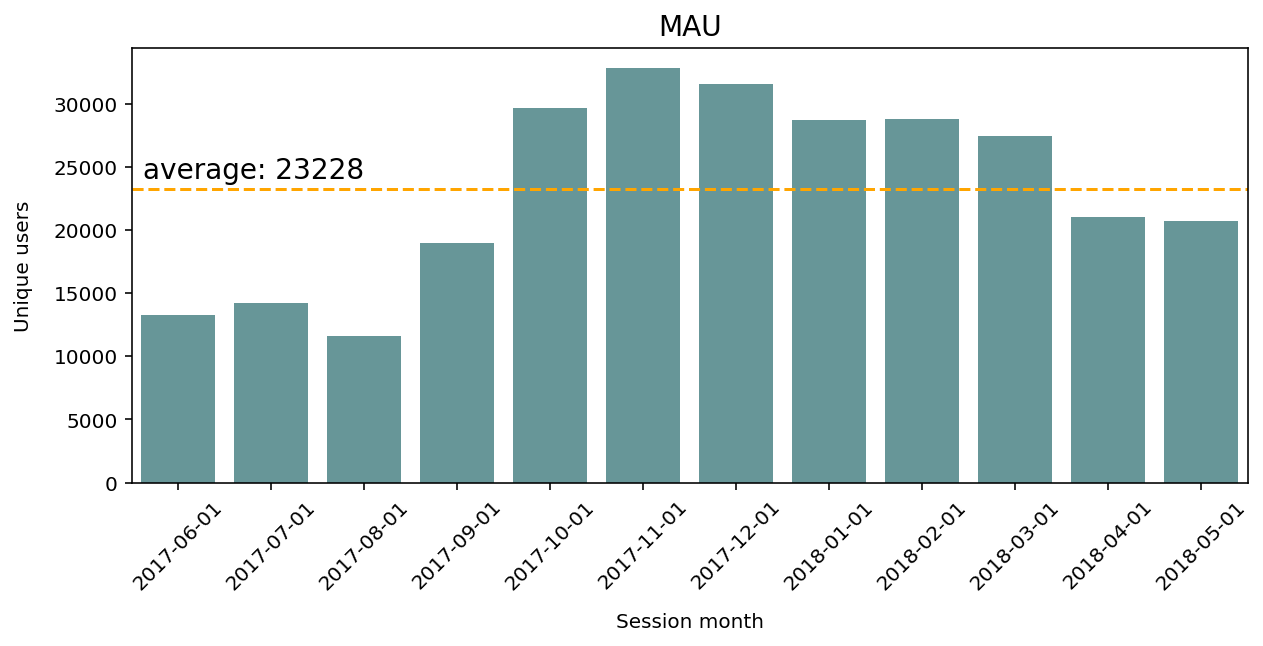

In [8]:
mau = visits.groupby(['trunc_month']).agg({'uid': 'nunique'}).reset_index()
mau_total = mau['uid'].mean()

fig, ax = plt.subplots(figsize=(10, 4))
plt.xticks(rotation=45)
sns.barplot(data=mau, x='trunc_month', y='uid', linewidth=1.5, color='cadetblue')
ax.axhline(y=mau_total, c='orange', ls='--', lw=1.5);
ax.annotate(f'average: {mau_total:.0f}', xy=(0.02, 0.70), xycoords='axes fraction',
            xytext=(0.01, 0.70), textcoords='axes fraction', fontsize=14);
ax.set_title('MAU', fontsize=14)
ax.set_xlabel('Session month', labelpad=10)
ax.set_ylabel('Unique users', labelpad=10);

#### Conclusion 
The average MAU is 23228, with highs in cold months and lows in summer. 

---
#### How many people use it everyweek?

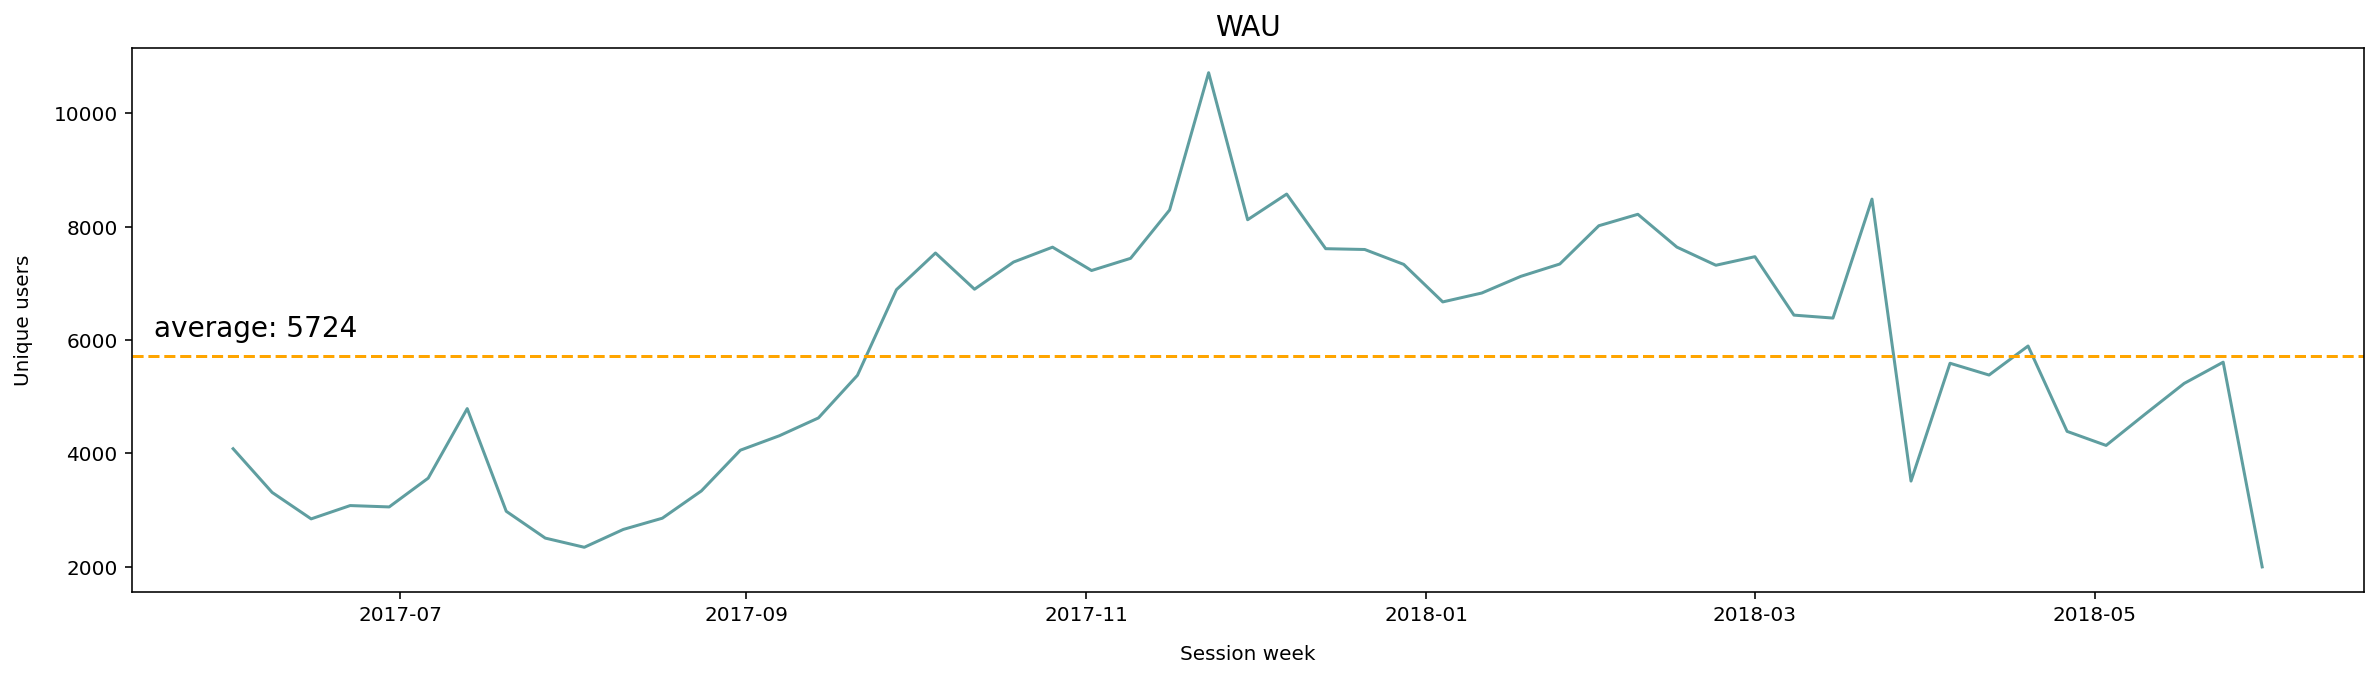

In [9]:
wau = visits.groupby(['trunc_week']).agg({'uid': 'nunique'}).reset_index()
wau_total = wau['uid'].mean()

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=wau, x='trunc_week', y='uid', linewidth=1.5, color='cadetblue')
ax.axhline(y=wau_total, c='orange', ls='--', lw=1.5);
ax.annotate(f'average: {wau_total:.0f}', xy=(0.01, 0.47),  xycoords='axes fraction',
            xytext=(0.01, 0.47), textcoords='axes fraction', fontsize=14);
ax.set_title('WAU', fontsize=14)
ax.set_xlabel('Session week', labelpad=10)
ax.set_ylabel('Unique users', labelpad=10);

#### Conclusion
The average WAU is 5724. Here we could see a prominent peak in November.

---
#### How many people use it every day? How many sessions are there per day?

In [10]:
dau = visits.groupby('session_date').agg({'uid': ['count', 'nunique']}).reset_index()
dau.columns = ['session_date', 'n_sessions', 'n_users']
dau['sessions_per_user'] = dau['n_sessions'] / dau['n_users']

dau_total = dau['n_users'].mean()
spd_total = dau['n_sessions'].mean()
spu_total = dau['sessions_per_user'].mean()

dau_max = dau[dau['n_users'] == dau['n_users'].max()]
dau_min = dau[dau['n_users'] == dau['n_users'].min()]

display(dau_max.style.hide_index())
display(dau_min.style.hide_index())

session_date,n_sessions,n_users,sessions_per_user
2017-11-24,4042,3319,1.217837


session_date,n_sessions,n_users,sessions_per_user
2018-03-31,1,1,1.000000


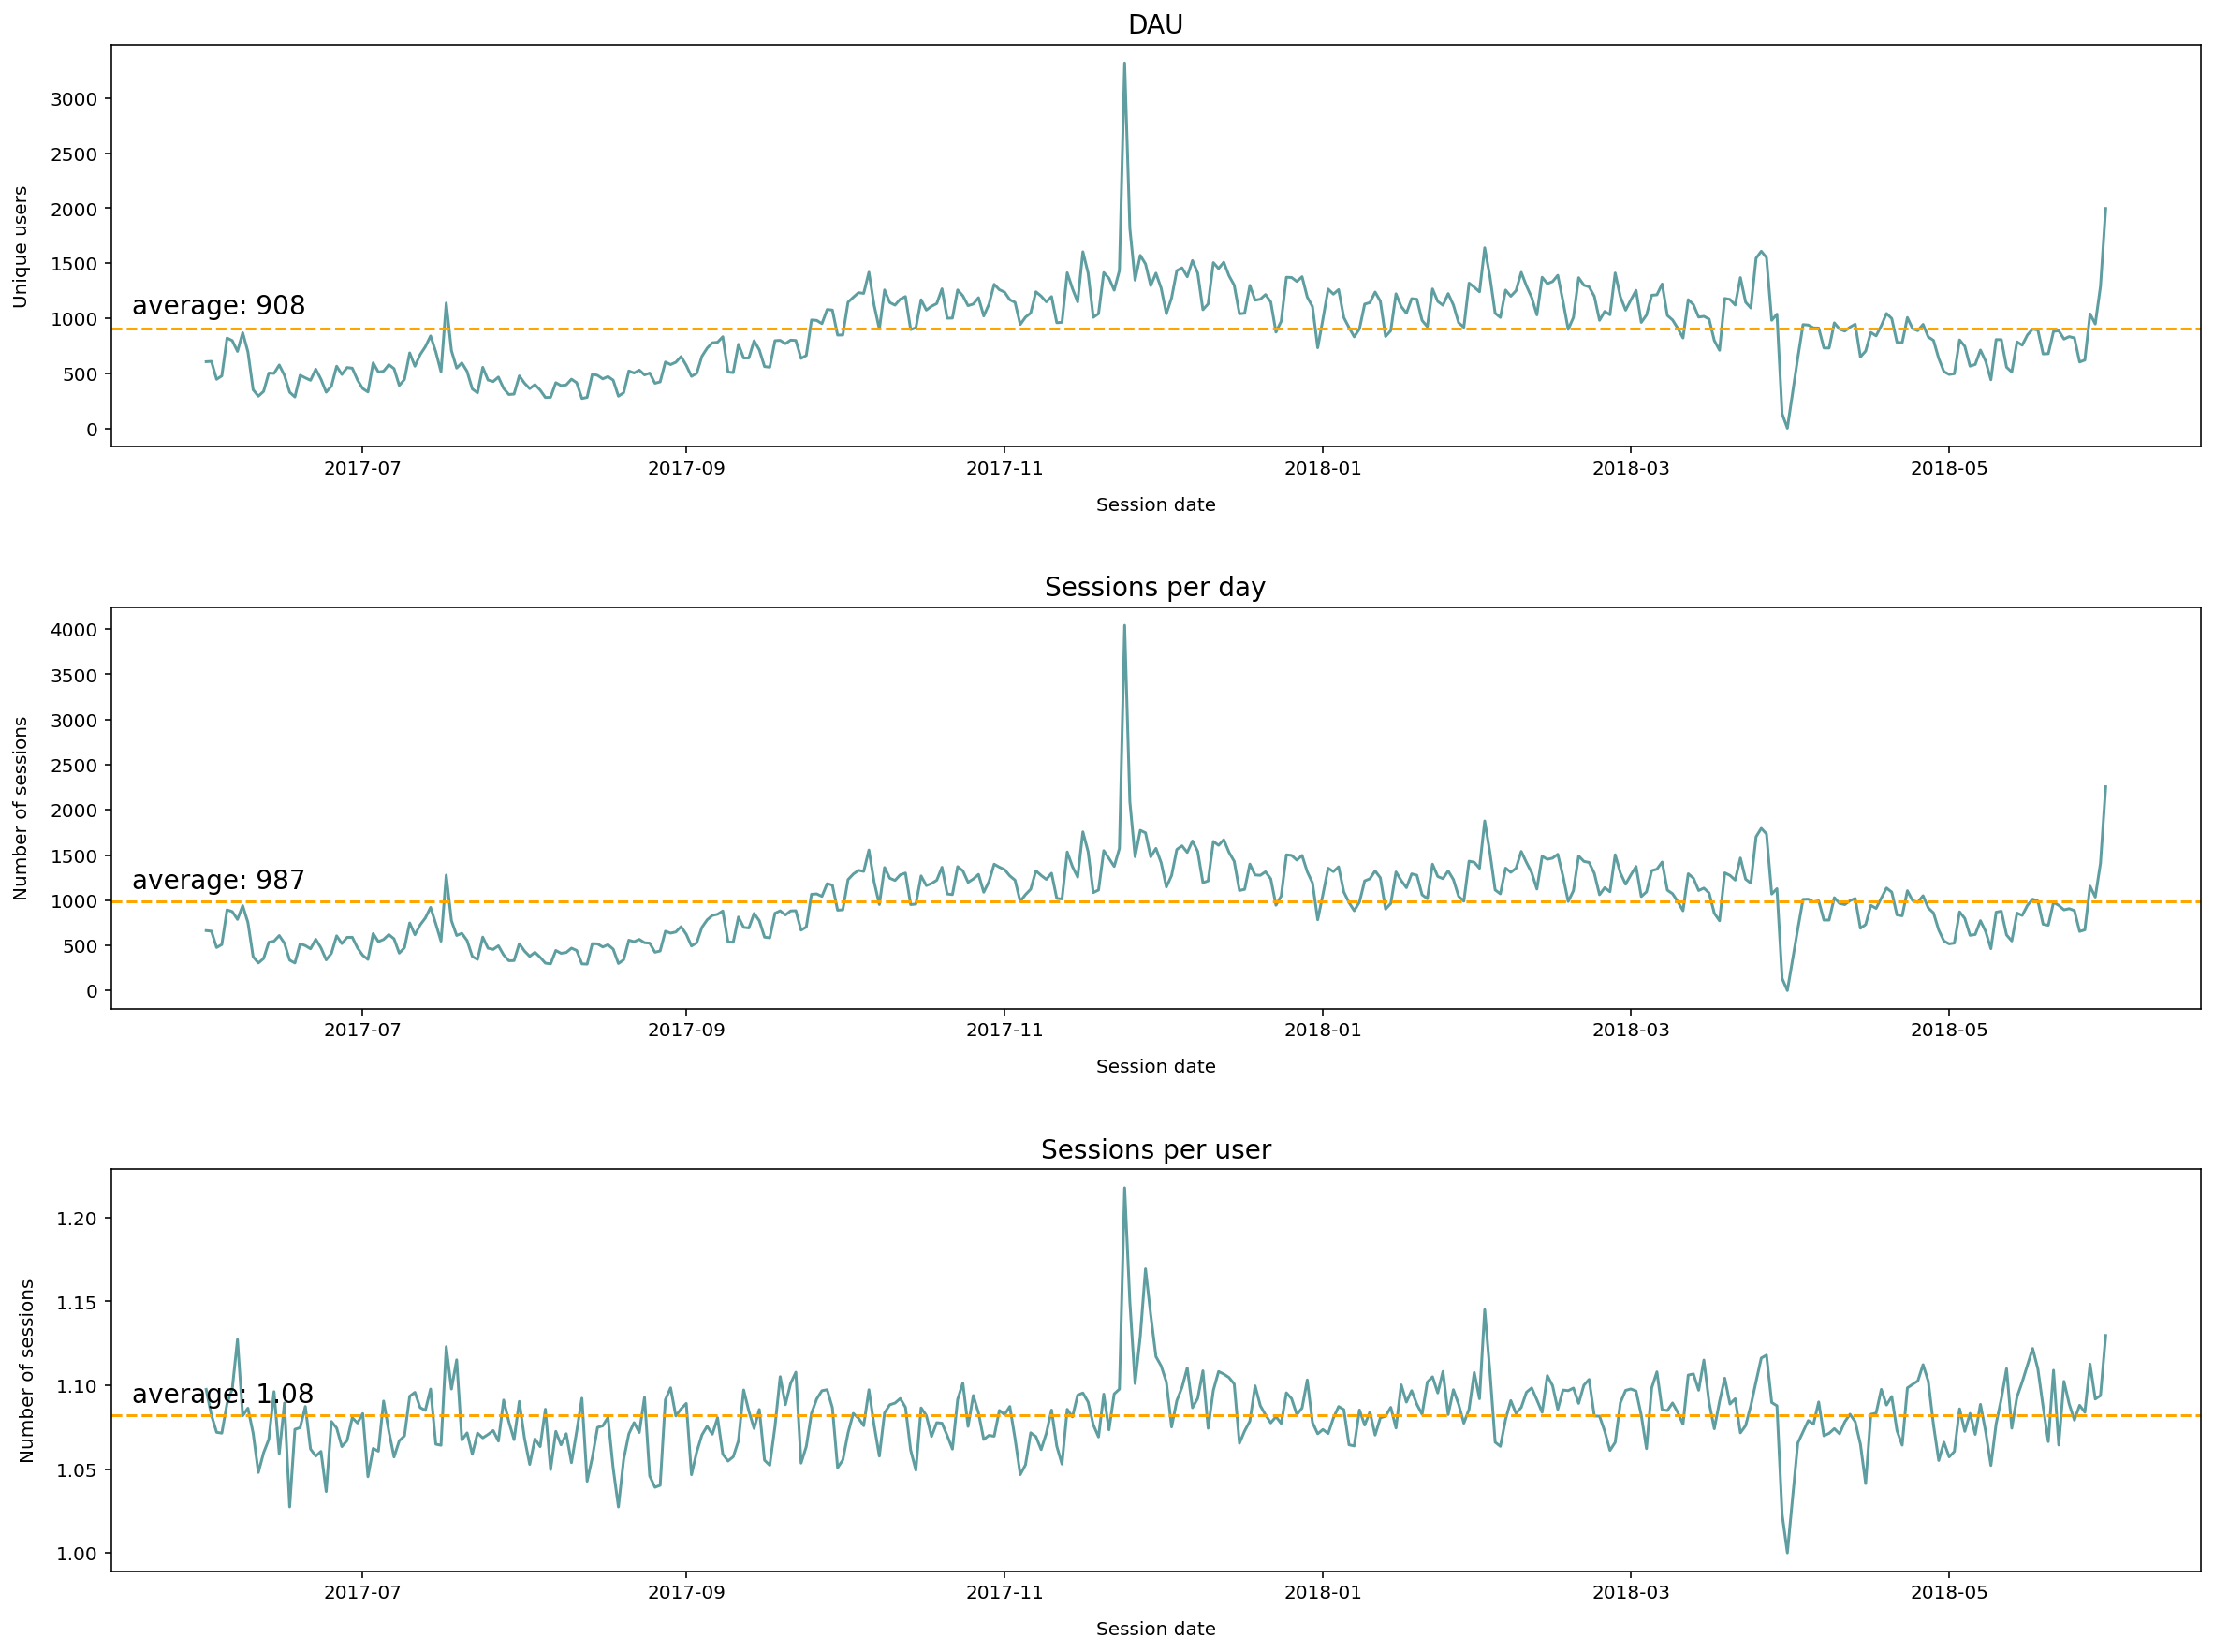

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
plt.subplots_adjust(hspace=0.4);

sns.lineplot(ax=ax[0], data=dau, x='session_date', y='n_users', linewidth=1.5, color='cadetblue')
ax[0].axhline(y=dau_total, c='orange', ls='--', lw=1.5);
ax[0].annotate(f'average: {dau_total:.0f}', xy=(0.01, 0.33),  xycoords='axes fraction',
                xytext=(0.01, 0.33), textcoords='axes fraction', fontsize=14);
ax[0].set_title('DAU', fontsize=14)
ax[0].set_xlabel('Session date', labelpad=10)
ax[0].set_ylabel('Unique users', labelpad=10);

sns.lineplot(ax=ax[1], data=dau, x='session_date', y='n_sessions', linewidth=1.5, color='cadetblue')
ax[1].axhline(y=spd_total, c='orange', ls='--', lw=1.5);
ax[1].annotate(f'average: {spd_total:.0f}', xy=(0.01, 0.3),  xycoords='axes fraction',
                xytext=(0.01, 0.3), textcoords='axes fraction', fontsize=14);
ax[1].set_title('Sessions per day', fontsize=14)
ax[1].set_xlabel('Session date', labelpad=10)
ax[1].set_ylabel('Number of sessions', labelpad=10);

sns.lineplot(ax=ax[2], data=dau, x='session_date', y='sessions_per_user', linewidth=1.5, color='cadetblue')
ax[2].axhline(y=dau['sessions_per_user'].mean(), c='orange', ls='--', lw=1.5);
ax[2].annotate(f'average: {spu_total:.2f}', xy=(0.01, 0.42),  xycoords='axes fraction',
                xytext=(0.01, 0.42), textcoords='axes fraction', fontsize=14);
ax[2].set_title('Sessions per user', fontsize=14)
ax[2].set_xlabel('Session date', labelpad=10)
ax[2].set_ylabel('Number of sessions', labelpad=10);

#### Conclusion

The average DAU is 908. We have a maximum of 3319 on 2007-11-24. I can't imagine any natural cause for this extremum; it is too early for a holiday presents preparation. Also, there is a minimum of 1 (one) visit on 2018-03-31. Maybe some data are missing here.

There are 987 average sessions per day, so we have 1.08 sessions per user (and this parameter is pretty stable).

---
#### What is the length of each session?

count   359400.00
mean       643.05
std        997.10
min          0.00
25%        120.00
50%        300.00
75%        840.00
max      42660.00
Name: session_length, dtype: float64

Zero length sessions: 35794 (9.96%)
Very large sessions: 26213 (7.29%)


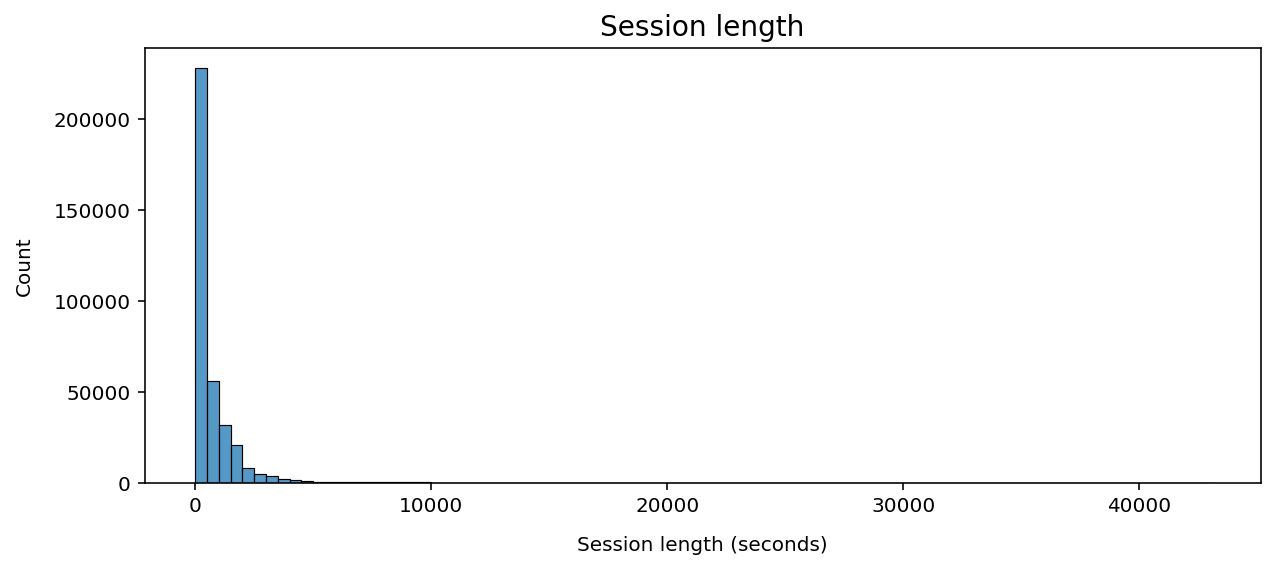

In [12]:
display(visits['session_length'].describe())

zerocount = visits[visits['session_length']==0].shape[0]
print('Zero length sessions: {0} ({1:.2%})'.format(zerocount, zerocount/visits.shape[0]))

q1 = visits['session_length'].quantile(.25)
q3 = visits['session_length'].quantile(.75)
upper = q3 + 1.5 * (q3 - q1)

largecount = visits[visits['session_length'] > upper].shape[0]
print('Very large sessions: {0} ({1:.2%})'.format(largecount, largecount/visits.shape[0]))

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(visits, x='session_length', binwidth=500);
ax.set_title('Session length', fontsize=14)
ax.set_xlabel('Session length (seconds)', labelpad=10)
ax.set_ylabel('Count', labelpad=10);

Desktop average session length: 515
Touch average session length: 427


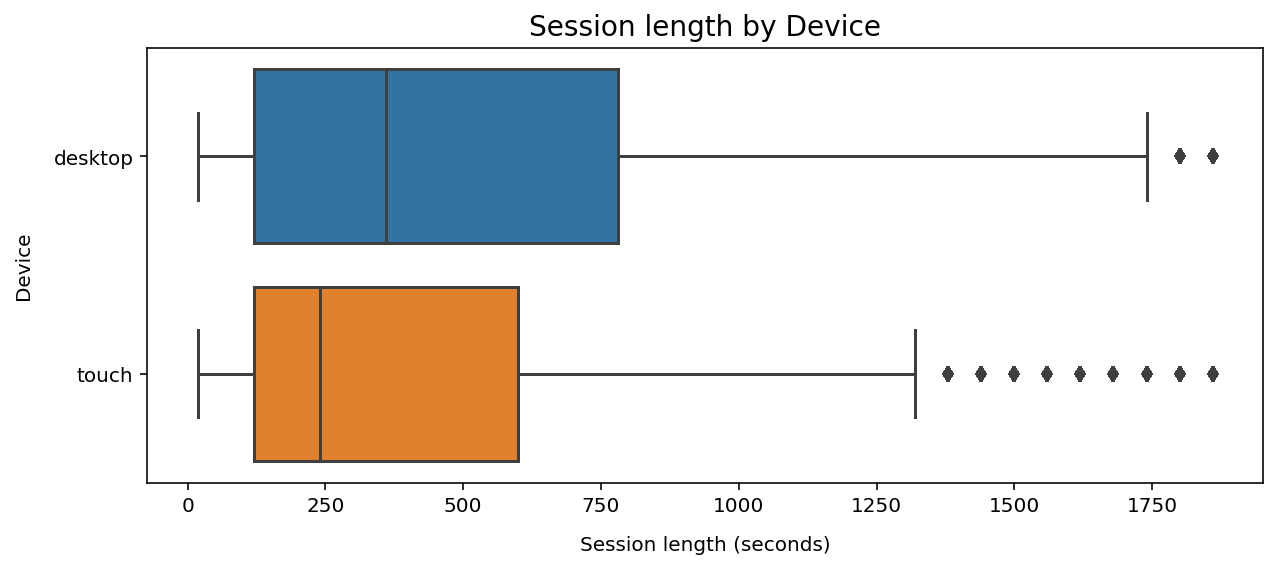

In [13]:
middlevisits = visits[(visits['session_length'] != 0) & (visits['session_length'] < upper)]

desktop_avg = middlevisits[middlevisits['device']=='desktop']['session_length'].mean()
touch_avg = middlevisits[middlevisits['device']=='touch']['session_length'].mean()
print(f'Desktop average session length: {desktop_avg:.0f}')
print(f'Touch average session length: {touch_avg:.0f}')

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=middlevisits, y='device', x='session_length')
ax.set_title('Session length by Device', fontsize=14)
ax.set_xlabel('Session length (seconds)', labelpad=10)
ax.set_ylabel('Device', labelpad=10);

#### Conclusion

The distribution of sessions' length is skewed, with half of the sessions less than 300 seconds and a maximum of 84480 seconds.  
We have 9.96% zero-length sessions and 6.86% sessions larger than Q3+1.5IQR.

If we exclude these zero and lengthy sessions, we could see that the average session length for desktop is more significant than for the touch (515 and 427 seconds, respectively). Does this mean that the touch interface is easier to use, or do people explore more options from the desktop? Comparing these groups could be a potential direction for further analysis. 

---
#### How often do users come back?

In [14]:
first_visit_date = visits.groupby(['uid'])['session_date'].min().reset_index()
first_visit_date.columns = ['uid', 'first_visit_date']

visits = visits.merge(first_visit_date, on='uid')
visits['first_visit_month'] = pd.to_datetime(visits['first_visit_date'].values.astype('datetime64[M]')).date

visits['month'] = (visits['trunc_month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')
visits['month'] = visits['month'].round().astype(int) 

cohorts = visits.groupby(['first_visit_month', 'month']).agg({'uid': 'nunique'}).reset_index()
cohorts.columns = ['first_visit_month','month', 'n_users']

initial_users_count = cohorts[cohorts['month'] == 0][['first_visit_month', 'n_users']]
initial_users_count = initial_users_count.rename(columns={'n_users': 'cohort_users'})

cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
cohorts['retention'] = cohorts['n_users'] / cohorts['cohort_users']

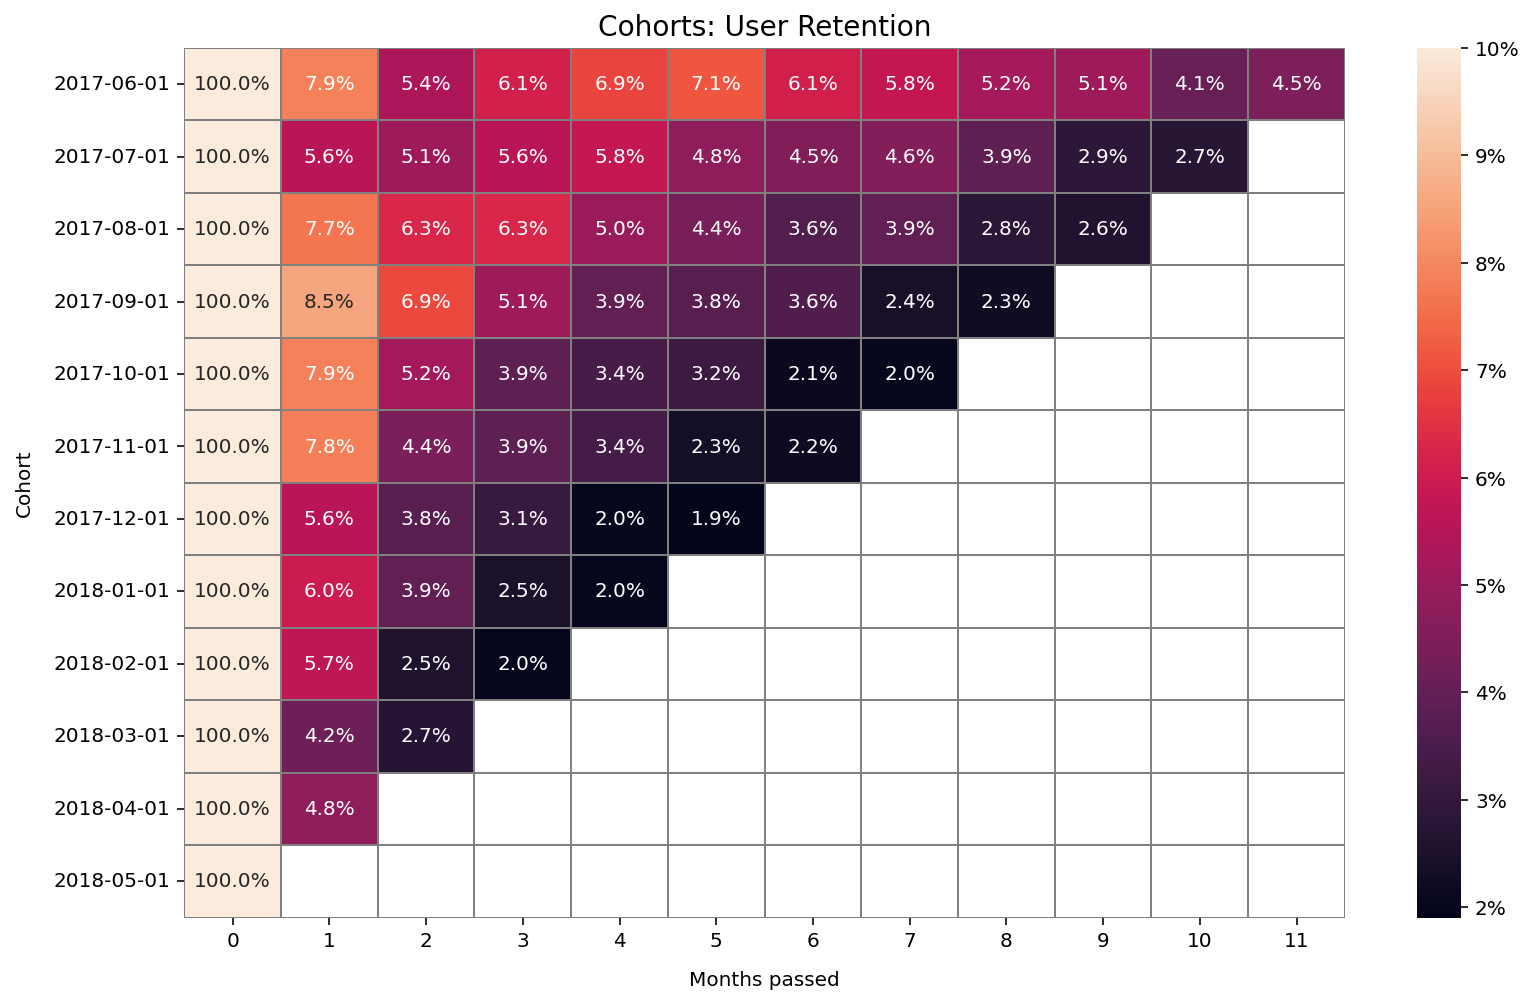

In [15]:
retention_pivot = cohorts.pivot_table(
    index='first_visit_month',
    columns='month',
    values='retention',
    aggfunc='sum',
)

fig, ax = plt.subplots(figsize=(13, 8))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1, ax=ax)
ax.set_title('Cohorts: User Retention', fontsize=14)
ax.set_xlabel('Months passed', labelpad=10)
ax.set_ylabel('Cohort', labelpad=10);
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0));

#### Conclusion

Overall retention rate shows a considerable drop in the first month and then slowly decreases further.  
Also, we could see that user retention starting from the December cohort is significantly lower, while the first cohort has noticeably higher rates.

---
### Sales

#### When do people start buying?

In [16]:
first_order_date = orders.groupby(['uid'])['buy_date'].min().reset_index()
first_order_date.columns = ['uid', 'first_order_date']

conversion = first_visit_date.merge(first_order_date, on='uid', how='left')
conversion['conversion']=((pd.to_datetime(conversion['first_order_date']) - \
                           pd.to_datetime(conversion['first_visit_date'])) / \
                          np.timedelta64(1,'D'))

count   36523.00
mean       16.90
std        47.07
min         0.00
25%         0.00
50%         0.00
75%         2.00
max       363.00
Name: conversion, dtype: float64

The overall conversion is 16.0%


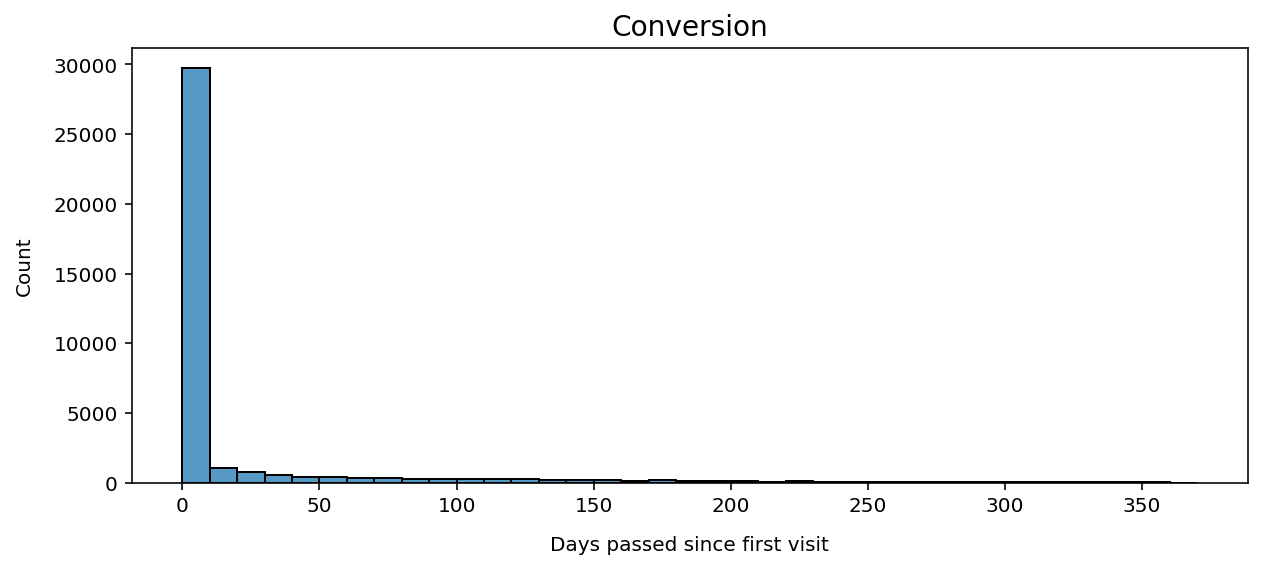

In [17]:
display(conversion[conversion['conversion'].notna()]['conversion'].describe())

print('The overall conversion is {:.1%}'.format(orders['uid'].nunique() / visits['uid'].nunique()))

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(conversion[conversion['conversion'].notna()], x='conversion', binwidth=10);
ax.set_title('Conversion', fontsize=14)
ax.set_xlabel('Days passed since first visit', labelpad=10)
ax.set_ylabel('Count', labelpad=10);

#### Conclusion

Our median conversion is zero-days, but some visitors convert after 100, 200 and even at 363 days.

----
#### How many orders do they make during a given period of time?

In [18]:
orders = orders.merge(first_order_date, on='uid')

orders['first_order_month'] = pd.to_datetime(orders['first_order_date'].values.astype('datetime64[M]')).date
orders['month'] = (orders['trunc_month'] - orders['first_order_month']) / np.timedelta64(1, 'M')
orders['month'] = orders['month'].round().astype(int) 

ordercohorts = orders.groupby(['first_order_month', 'month']). \
                            agg({'uid': ['nunique', 'count'], 'revenue': ['mean', 'sum']}).reset_index()
ordercohorts.columns = ['first_order_month', 'month', 'n_buyers', 'n_purchases', 'avg_rev', 'sum_rev']

initial_buyers_count = ordercohorts[ordercohorts['month'] == 0][['first_order_month', 'n_buyers']]
initial_buyers_count = initial_buyers_count.rename(columns={'n_buyers': 'cohort_size'})

ordercohorts = ordercohorts.merge(initial_buyers_count, on='first_order_month')

ordercohorts['orders_per_buyer'] = ordercohorts['n_purchases'] / ordercohorts['cohort_size']

In [19]:
cohort_piv = ordercohorts.pivot_table(
    index='first_order_month', 
    columns='month', 
    values='orders_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)

print('Median of purchases per customer: {0:.2f}'.format(cohort_piv.median().median()))

cohort_piv.round(2).fillna('')

Median of purchases per customer: 1.43


month,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.70,1.84,1.92,2.03,2.10,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.20,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.60,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.50,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.30,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


#### Conclusion

The median number of purchases per customer is 1.43, which correlates with our low retention rates. Most customers make a purchase or two in the first month, and then only a small number of them come back.  
Also, from cumulative purchases per customer, we could see that the first cohort has a higher purchase per customer number.

---
#### What is the average purchase size?

count   50415.00
mean        5.00
std        21.82
min         0.00
25%         1.22
50%         2.50
75%         4.89
max      2633.28
Name: revenue, dtype: float64

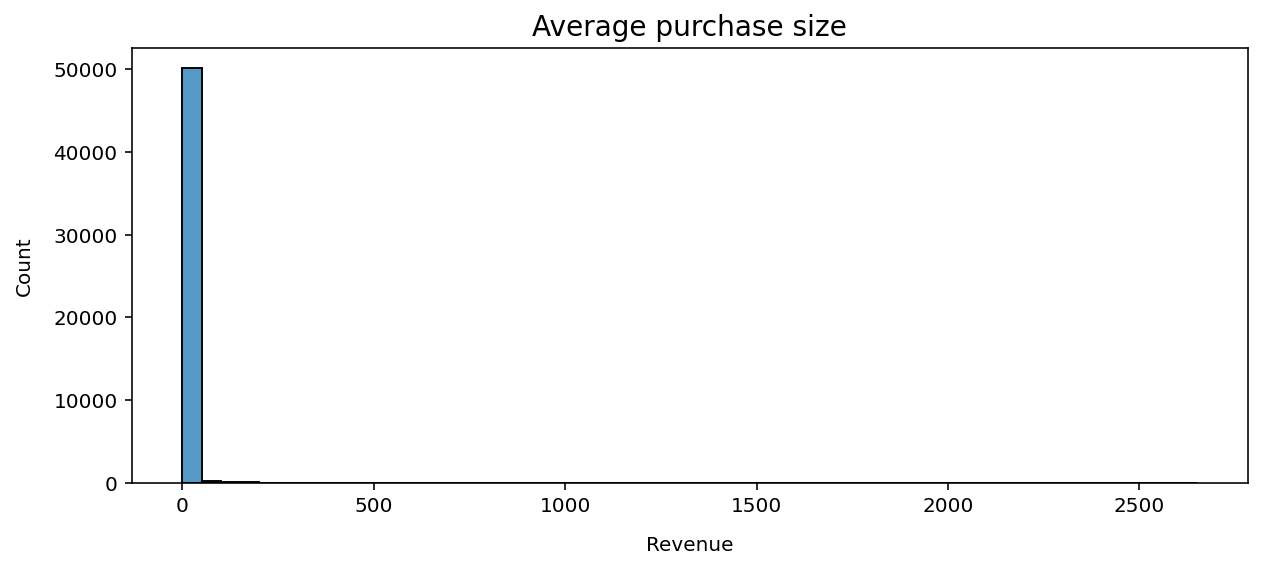

In [20]:
display(orders['revenue'].describe())

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(orders, x='revenue', binwidth=50);
ax.set_title('Average purchase size', fontsize=14)
ax.set_xlabel('Revenue', labelpad=10)
ax.set_ylabel('Count', labelpad=10);

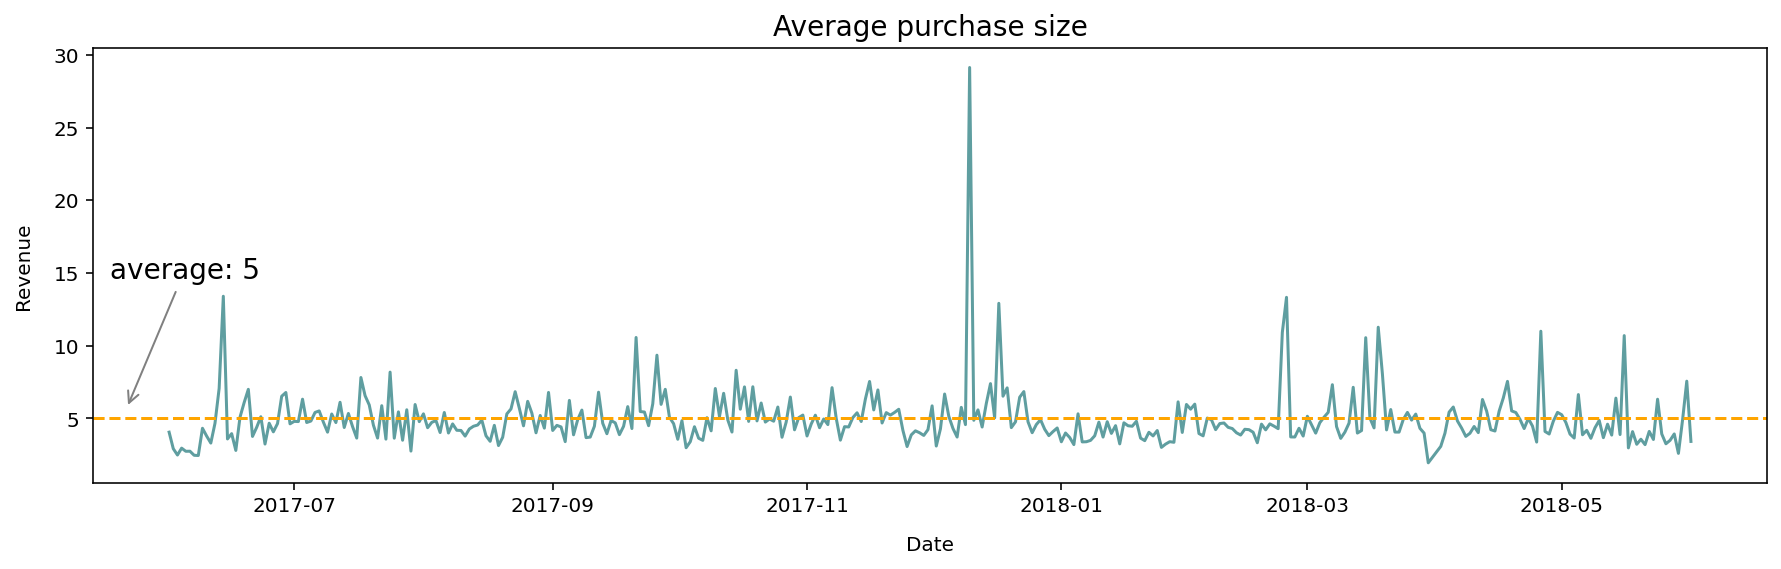

In [21]:
avg_revenue = orders['revenue'].mean()

fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(data=orders, x='buy_date', y='revenue', linewidth=1.5, color='cadetblue', ci=None)

ax.axhline(y=avg_revenue, c='orange', ls='--', lw=1.5);
ax.annotate(f'average: {avg_revenue:.0f}', xy=(0.02, 0.17), xycoords='axes fraction', fontsize=14,
            xytext=(0.01, 0.47), textcoords='axes fraction', arrowprops={'arrowstyle': '->', 'color': 'gray'});

ax.set_title('Average purchase size', fontsize=14)
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Revenue', labelpad=10);

In [22]:
avg_cohort_piv = orders.pivot_table(
    index='first_order_month', 
    columns='month', 
    values='revenue', 
    aggfunc='mean'
)

avg_cohort_piv.round(2).fillna('')

month,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.70,5.60,,
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,,,
2017-10-01,4.37,7.41,5.13,5.59,5.10,5.07,4.28,4.01,,,,
2017-11-01,4.37,4.10,4.47,6.28,4.44,3.73,4.60,,,,,
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,,,,,,
2018-01-01,3.69,4.44,6.45,7.52,2.71,,,,,,,
2018-02-01,3.71,4.58,3.45,3.87,,,,,,,,


#### Conclusion

The distribution on the average purchase size is skewed with a mean of 5 and a median of 2.5.  
The starting average purchase size is almost similar across all the cohorts. But in further months, the cohorts from September and December have significantly larger average purchase sizes.

---
#### How much money do they bring? (LTV)

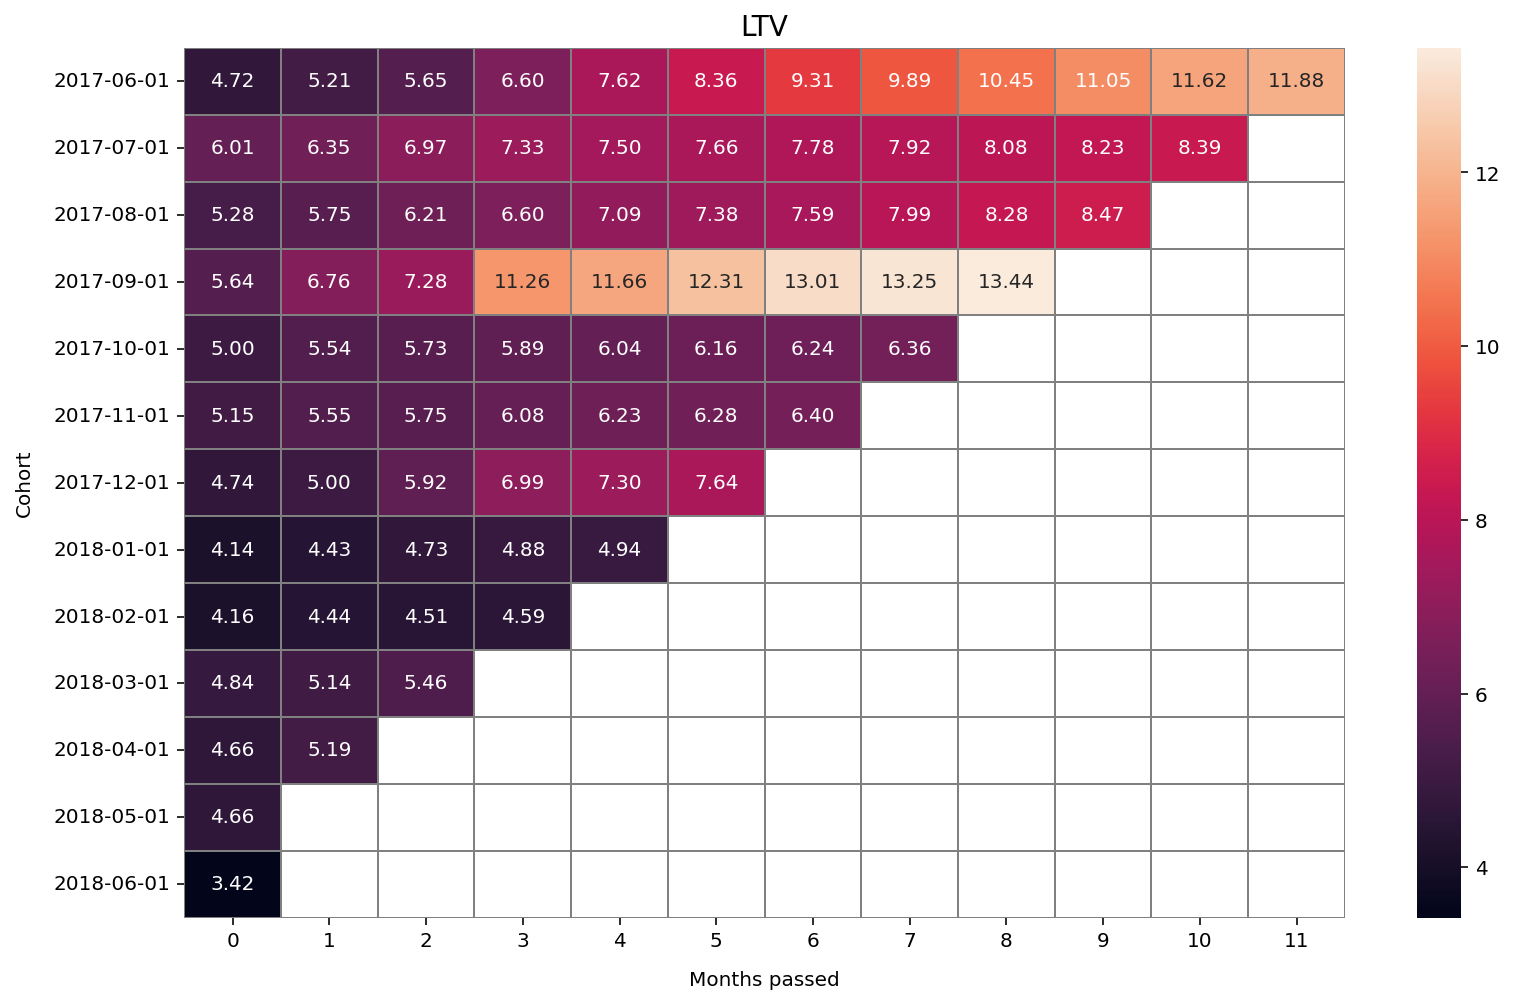

In [23]:
MARGIN_RATE = 1

ordercohorts['ltv'] = (ordercohorts['sum_rev'] * MARGIN_RATE) / ordercohorts['cohort_size']

ltv_pivot = ordercohorts.pivot_table(
    index='first_order_month',
    columns='month',
    values='ltv',
    aggfunc='sum',
).cumsum(axis=1)

fig, ax = plt.subplots(figsize=(13, 8))
sns.heatmap(ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
ax.set_title('LTV', fontsize=14)
ax.set_xlabel('Months passed', labelpad=10)
ax.set_ylabel('Cohort', labelpad=10);

#### Conclusion
For purposes of cohort analysis, LTV is a cohort's cumulative revenue, accounting for the number of people in the cohort (margin rate = 1).  
After six months, we could see two outstanding cohorts: the one from June that has the best retention rate and the one from September that has a very high average purchase size.

---
### Marketing

#### How much money was spent?

In [24]:
costs = costs.sort_values(by=['dt','source_id'])

print('Total marketing cost is {}'.format(costs['costs'].sum()))
costs_per_source = costs.groupby(['source_id'])['costs'].sum().reset_index()
costs_per_source.style.hide_index()

Total marketing cost is 329131.625


source_id,costs
1,20833.269531
2,42806.039062
3,141321.625000
4,61073.601562
5,51757.101562
9,5517.490234
10,5822.490234


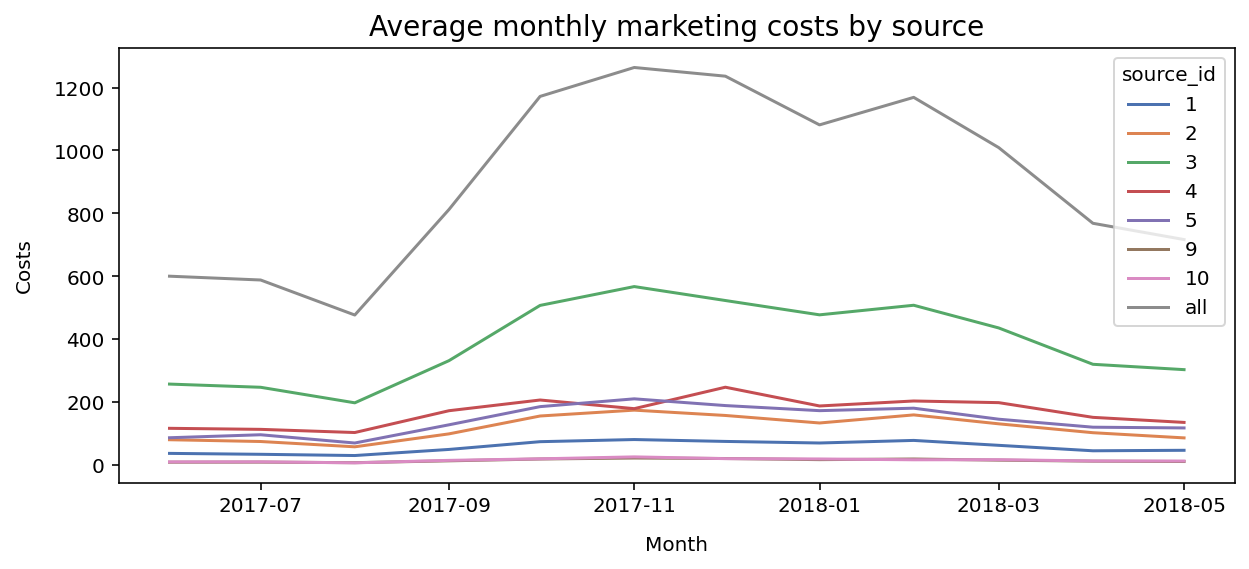

In [25]:
month_avg_costs = costs.groupby(['source_id', 'month'])['costs'].mean().reset_index()
month_avg_costs
total = month_avg_costs.groupby('month')['costs'].sum().reset_index()
total['source_id'] = 'all'
month_avg_costs = month_avg_costs.append(total, ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=month_avg_costs, x='month', y='costs', hue='source_id', palette='deep')
ax.set_title('Average monthly marketing costs by source', fontsize=14)
ax.set_xlabel('Month', labelpad=10)
ax.set_ylabel('Costs', labelpad=10);

#### Conclusion

This average monthly marketing spending graph explains a more significant number of active users in the winter months. With low retention rates, most of the visitors are new, which means we had some marketing expenses to acquire them. So more costs equal more visitors.

---
#### How much did customer acquisition from each of the sources cost?

In [26]:
costs_by_month = costs.groupby(['month'])['costs'].sum().reset_index()
costs_by_month.columns = ['first_order_month', 'costs']
cac_per_month = costs_by_month.merge(initial_buyers_count, on=['first_order_month'], how='left')
cac_per_month['CAC'] = cac_per_month['costs'] / cac_per_month['cohort_size']
cac_per_month.style.hide_index()

first_order_month,costs,cohort_size,CAC
2017-06-01,18015.000000,2023,8.905091
2017-07-01,18240.589844,1923,9.485486
2017-08-01,14790.540039,1370,10.796015
2017-09-01,24368.910156,2581,9.441654
2017-10-01,36322.878906,4340,8.369327
2017-11-01,37907.878906,4081,9.288870
2017-12-01,38315.351562,4383,8.741810
2018-01-01,33518.519531,3373,9.937302
2018-02-01,32723.029297,3651,8.962758
2018-03-01,30415.269531,3533,8.608907


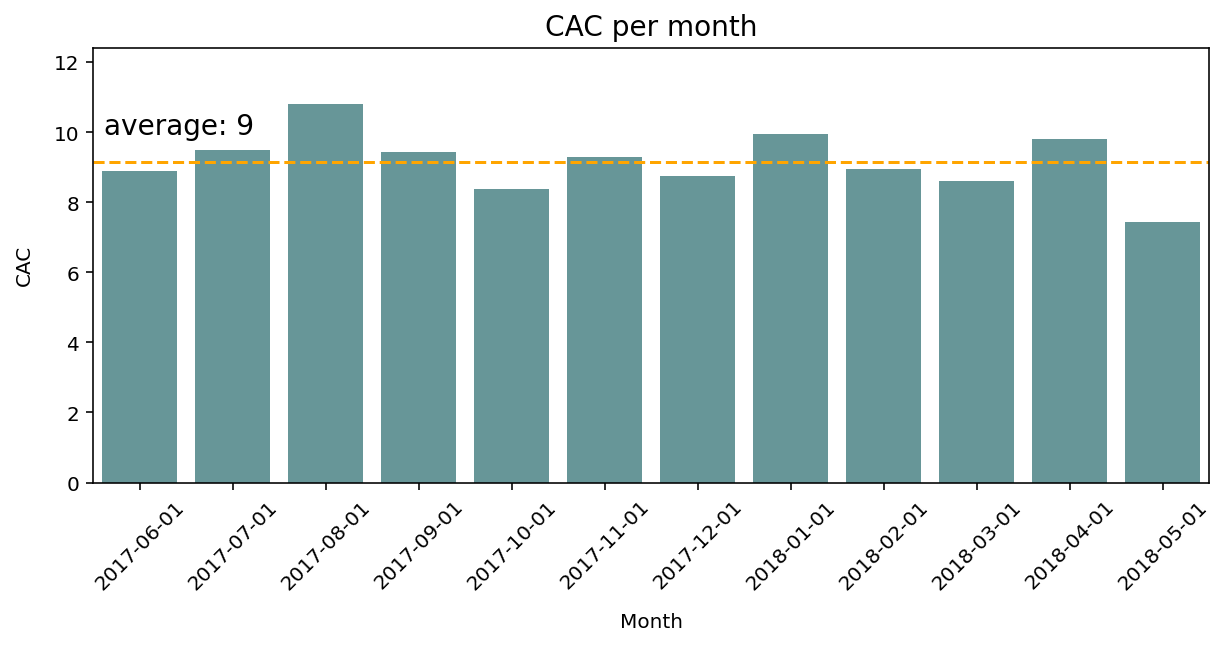

In [27]:
avg_cac = cac_per_month['CAC'].mean()

fig, ax = plt.subplots(figsize=(10, 4))
plt.xticks(rotation=45)
sns.barplot(data=cac_per_month, x='first_order_month', y='CAC', linewidth=1.5, color='cadetblue')

ax.axhline(y=avg_cac, c='orange', ls='--', lw=1.5);
ax.annotate(f'average: {avg_cac:.0f}', xy=(0.02, 0.80),  xycoords='axes fraction',
            xytext=(0.01, 0.80), textcoords='axes fraction', fontsize=14);

ax.set_title('CAC per month', fontsize=14)
ax.set_xlabel('Month', labelpad=10)
ax.set_ylabel('CAC', labelpad=10);
ax.set_ymargin(0.15)

#### Conclusion
The average CAC is around nine except for the last month when it became significantly lower.

---
#### CAC per source

In [28]:
first_source = visits.sort_values('start_ts').groupby('uid').first()['source_id'].reset_index()
first_source.columns = ['uid', 'first_source']
orders = orders.merge(first_source, on=['uid'], how='left')

costs_by_month_source = costs.groupby(['month','source_id'])['costs'].sum().reset_index()

orders_per_month_source = orders.groupby(['first_order_month', 'first_source'])['uid'].nunique().reset_index()
orders_per_month_source.columns = ['month', 'source_id', 'buyers']

cac_per_month_source = costs_by_month_source.merge(orders_per_month_source, how='left', on=['month', 'source_id'])
cac_per_month_source['CAC'] = cac_per_month_source['costs'] / cac_per_month_source['buyers']


orders_by_source = orders.groupby(['first_source'], as_index=False).agg({'uid':'nunique'}).\
                rename(columns={'uid':'n_buyers', 'first_source':'source_id'})
costs_by_source = costs.groupby('source_id', as_index=False).agg({'costs': 'sum'})
avg_CAC = orders_by_source.merge(costs_by_source, on='source_id')
avg_CAC['CAC'] = avg_CAC['costs'] / avg_CAC['n_buyers']

In [29]:
#Reviewer's code
orders.groupby(['first_source'], as_index=False).agg({'uid':'nunique'}).\
                rename(columns={'uid':'n_buyers', 'first_source':'source_id'})\
    .merge(costs.groupby('source_id', as_index=False).agg({'costs': 'sum'}), on='source_id')\
    .assign(cac = lambda row: row['costs'] / row['n_buyers'])\
    .set_index('source_id')[['cac']].style.bar(color='#98C6FF')

,cac
source_id,
1,7.186364
2,12.209367
3,13.493901
4,5.931779
5,7.467480
9,5.071223
10,4.381106


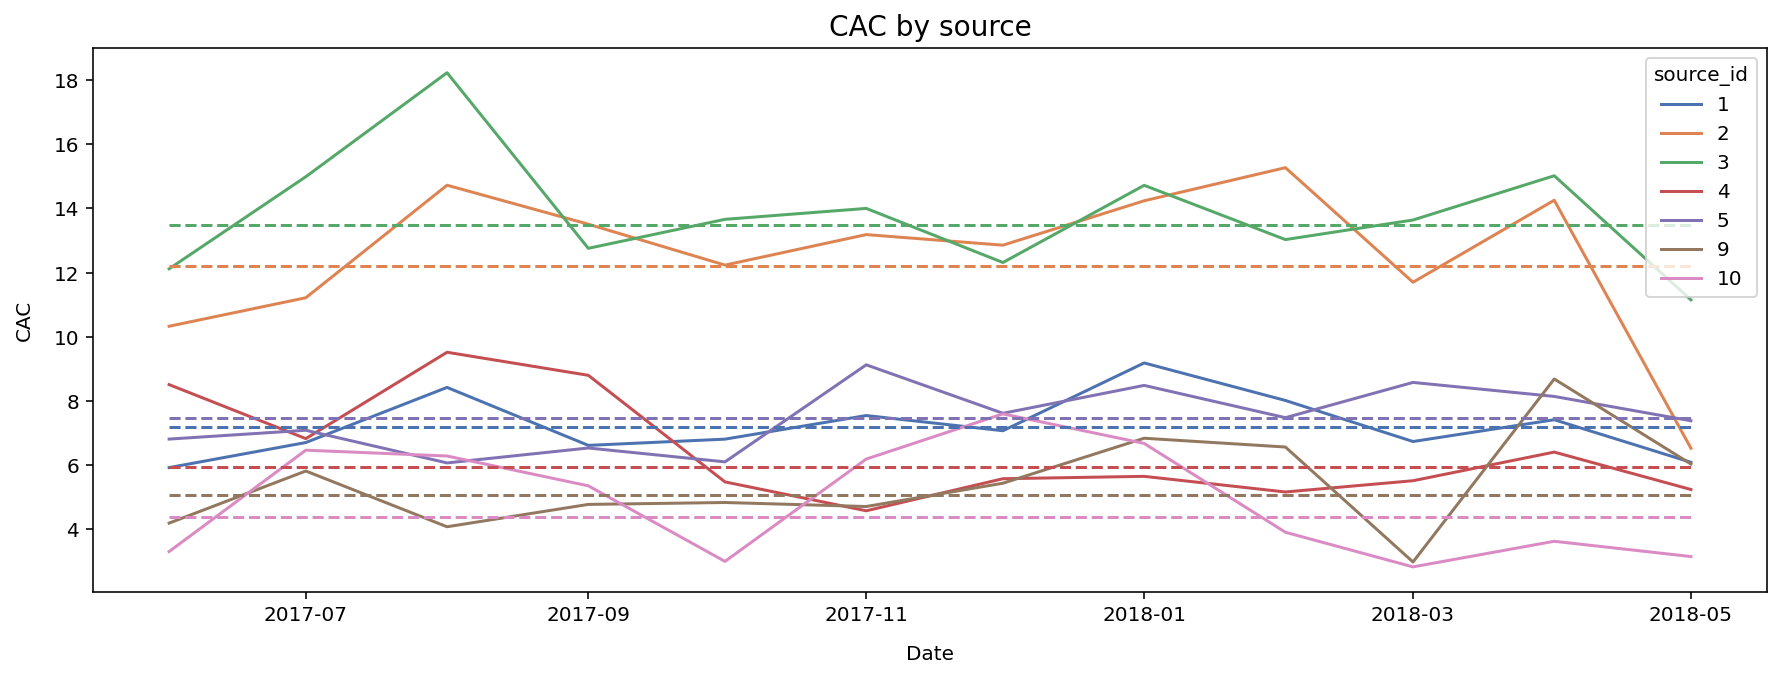

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=cac_per_month_source, x='month', y='CAC', hue='source_id', palette='deep')

min_month = cac_per_month_source['month'].min()
max_month = cac_per_month_source['month'].max()
ax.hlines(data=avg_CAC, xmin=min_month, xmax=max_month, y='CAC', linestyles='--', colors=sns.color_palette('deep'))

ax.set_title('CAC by source', fontsize=14)
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('CAC', labelpad=10);

#### Conclusion
The CAC is not equal for different sources. Sources two and three are the most expensive and source ten the cheapest.

---
#### How worthwhile where the investments? (ROI)

In [31]:
cac_per_month_ROI = cac_per_month[['first_order_month','CAC']]

roi = ordercohorts.merge(cac_per_month_ROI, on=['first_order_month'], how='left')

roi['ROI'] = roi['ltv'] / roi['CAC']

roi_piv = roi.pivot_table(
    index='first_order_month',
    columns='month',
    values='ROI',
    aggfunc='sum',
).cumsum(axis=1) 

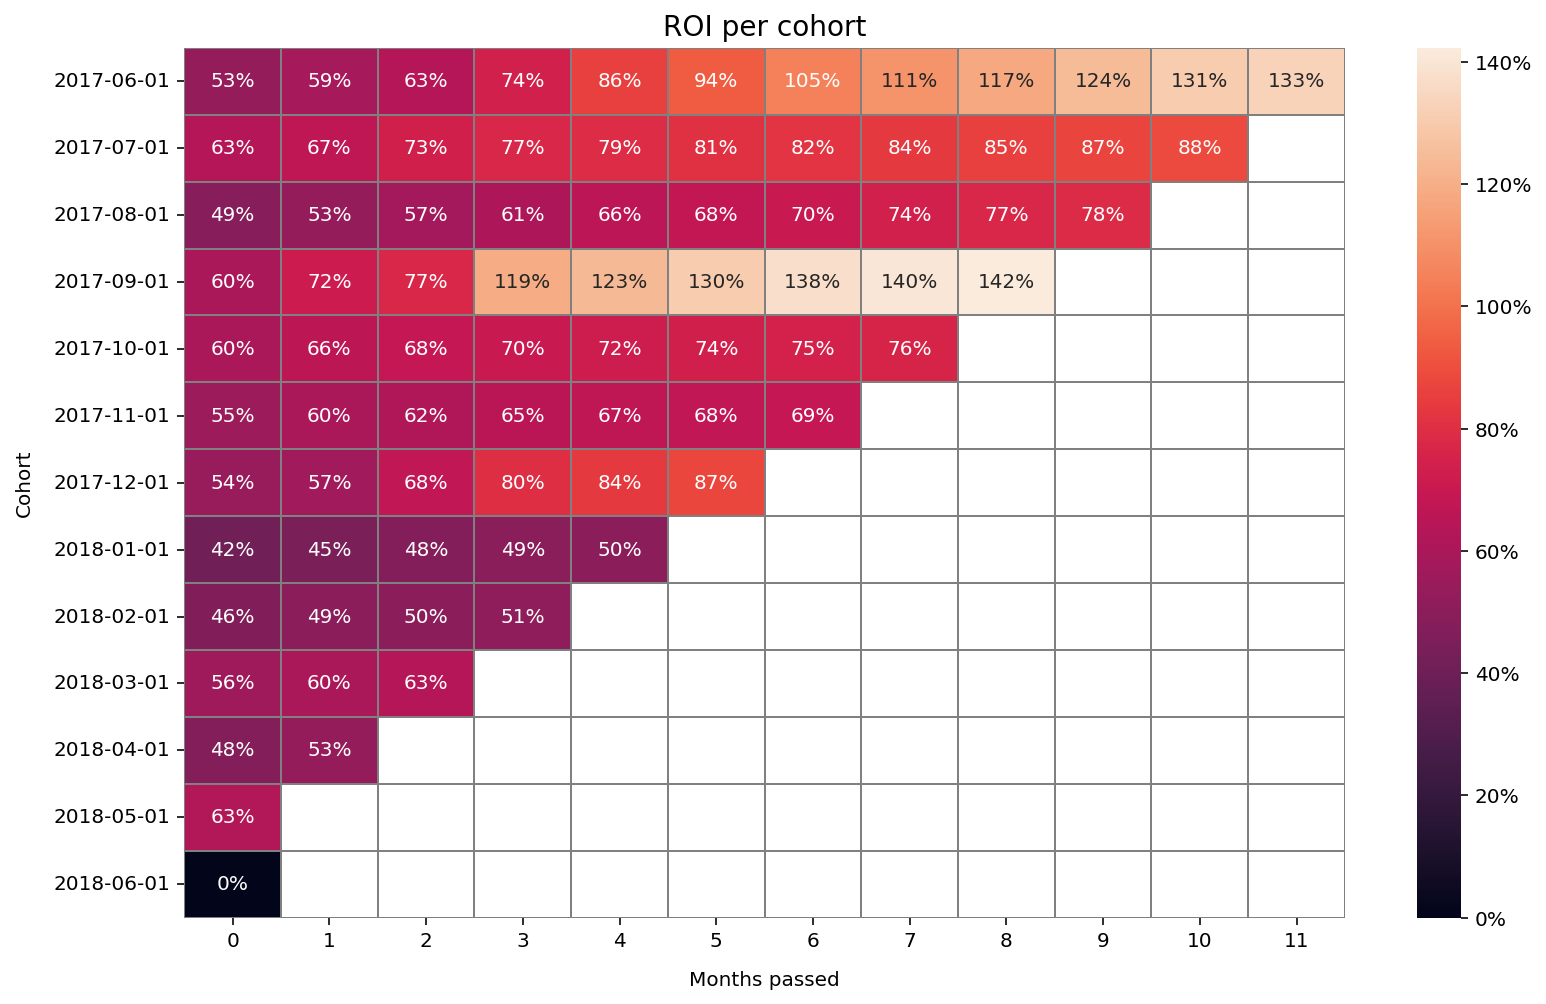

In [32]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.heatmap(roi_piv, annot=True, fmt='.0%',linewidths=1, linecolor='gray', ax=ax)
ax.set_title('ROI per cohort', fontsize=14)
ax.set_xlabel('Months passed', labelpad=10)
ax.set_ylabel('Cohort', labelpad=10);
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))

#### Conclusion
ROI per cohort doesn't look very positive. Only the September cohort got ROI larger than one on the third month and the June cohort on the sixth month.

In [33]:
ltv_per_source = orders.groupby(['first_source']).agg({'uid':'nunique','revenue':'sum'}).reset_index()
ltv_per_source.columns = ['source_id','buyers','revenue']
ltv_per_source['ltv'] = ltv_per_source['revenue'] / ltv_per_source['buyers']

roi_per_source = costs_per_source.merge(ltv_per_source, on=['source_id'])
roi_per_source['cac'] = roi_per_source['costs'] / roi_per_source['buyers']
roi_per_source['romi'] = roi_per_source['ltv'] / roi_per_source['cac']
roi_per_source.style.hide_index()

source_id,costs,buyers,revenue,ltv,cac,romi
1,20833.269531,2899,31090.550781,10.724578,7.186364,1.492351
2,42806.039062,3506,46923.609375,13.383802,12.209367,1.096191
3,141321.625000,10473,54511.238281,5.204931,13.493901,0.385725
4,61073.601562,10296,56696.832031,5.506685,5.931779,0.928336
5,51757.101562,6931,52624.019531,7.592558,7.467480,1.016750
9,5517.490234,1088,5759.399902,5.293566,5.071223,1.043844
10,5822.490234,1329,4450.330078,3.348631,4.381106,0.764334


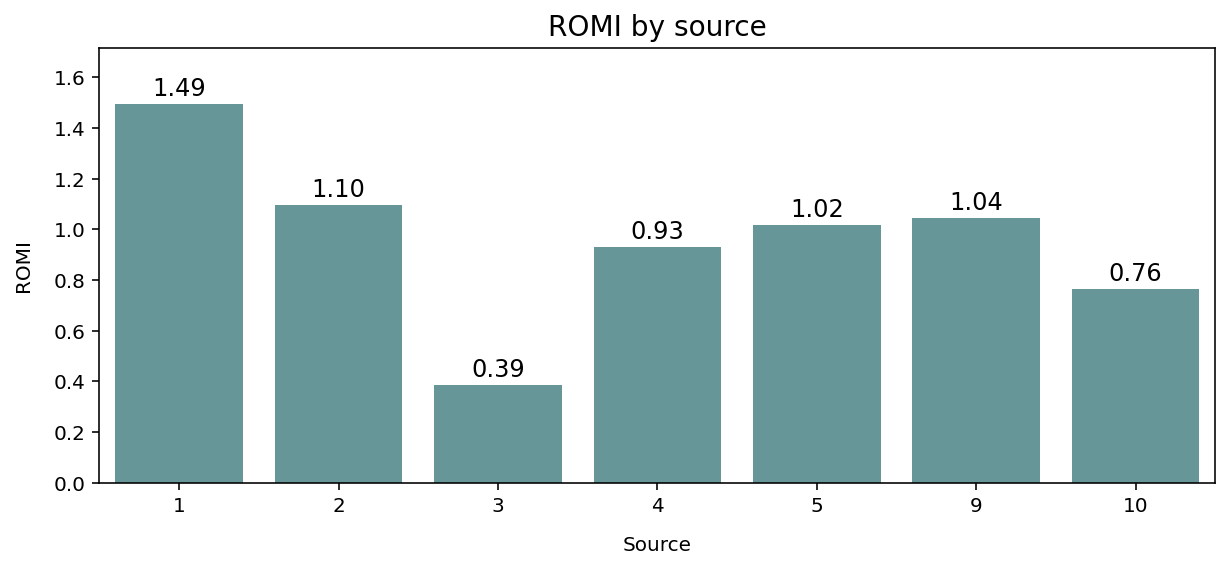

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
plots = sns.barplot(data=roi_per_source, x='source_id', y='romi', color='cadetblue')

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
    
ax.set_title('ROMI by source', fontsize=14)
ax.set_xlabel('Source', labelpad=10)
ax.set_ylabel('ROMI', labelpad=10);
ax.set_ymargin(0.15)

#### Conclusion
Splitting by source, we could see that only the first source has a ROMI of 1.71, while most of the sources are around one, and the third source has the lowest ROMI of 0.36. So maybe we should cut the third source entirely and spend more on the first.

## Overall conclusion

Here we have a dataset on Yandex.Afisha visits, orders and marketing expenses. We explored users' behaviour patterns to optimize marketing campaigns.

The first step was some preprocessing that consisted of reading some columns as datatimes and categories and renaming columns. Also, I added additional date parameters and dropped those that are not useful for further analysis.  
There were no missing values and no duplicates in this dataset.

We are starting the analysis with information about visits. The average MAU is 23228, and WAU is 5724, with highs in cold months and lows in summer.  
The average DAU is 908, the average number of sessions per day is 987,  and the average number of sessions per user is 1.08.  
It would not be beneficial to talk about the overall average session length  (the mean is 644 seconds, and the median is 300) since we have 9.96% zero-length sessions and 6.86% lengthy sessions (larger than Q3+1.5IQR). If we exclude these sessions, we get the average session length for desktop users of 515 seconds and touch users of 427 seconds.  
We don't see a high retention rate, and it is getting lower with later cohorts.

Looking at the orders' data, we see that the overall conversion rate is 16%. Half of the visitors convert in zero days and 3/4 in two days.  
The median number of purchases per customer is 1.43, which correlates with our low retention rates.  
The average purchase size has a mean of 5 and a median of 2.5. Its starting size is almost similar across all the cohorts, but the cohorts from September and December have significantly larger average purchase sizes in further months.  
This phenomenon contributes to different LTV across the cohorts. For example, the one from September has a significantly larger LTV in three months. Also, the cohort from June with the highest retention rate is doing better than the others.

And finally, we analyzed marketing expenses.   
Total marketing cost was 329131, with the expenses on the third source being almost half of it (141321). Also, plotting the change in marketing costs over time, we found the cause of a more significant number of visitors in winter. These were the months with higher expenses.  
The average overall CAC was pretty stable (and high) for the whole time except for the last month. Splitting CAC by source, we found that it differs significantly.    
ROI per cohort was not impressive. The September and June cohorts show the best results here. The reason for it is the difference in CAC by sources. The third source haves a tiny ROMI of 0.36, while the first is much better, with the ROMI of 1.71.

Based on this data, I recommend cutting the expenses on source number three and redirecting these finances to the first source.